<a href="https://colab.research.google.com/github/smitioswal/Diabetic-Retinopathy-Analysis/blob/main/DS3_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os 
import cv2
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time

In [ ]:
IMAGE_DIRECTORY = 'C:/Users/Desktop/data_science_projects/diabetic_retinography_classification/data'

IMG_DIM = 224

LABELS = ['Healthy', 'Mild_DR', 'Moderate_DR', 'Proliferate_DR', 'Severe_DR']

In [ ]:
#Create Labelled dataset

full_dataset = []

for category in LABELS:
    path = os.path.join(IMAGE_DIRECTORY, category)
    class_no = LABELS.index(category)
    
    for image in os.listdir(path):
        images = cv2.imread(os.path.join(path, image), cv2.IMREAD_COLOR)
        resized_images = cv2.resize(images, (IMG_DIM, IMG_DIM), cv2.INTER_AREA)
        full_dataset.append([resized_images, class_no])
        
random.shuffle(full_dataset)   

In [ ]:
#Create arrays
from sklearn.utils.class_weight import compute_class_weight

X = []
y = []

for features, label in full_dataset:
    X.append(features)
    y.append(label)

    
X = np.array(X).reshape(-1, IMG_DIM, IMG_DIM, 3)
X = X / 255.0

y = np.array(y)
y = keras.utils.to_categorical(y)

#Create weightings for y (OHE)
y_integers = np.argmax(y, axis = 1) # selects the '1' from each One hot encoded row.
y_class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers) # class weight type, classes, y

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 100)


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 100)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

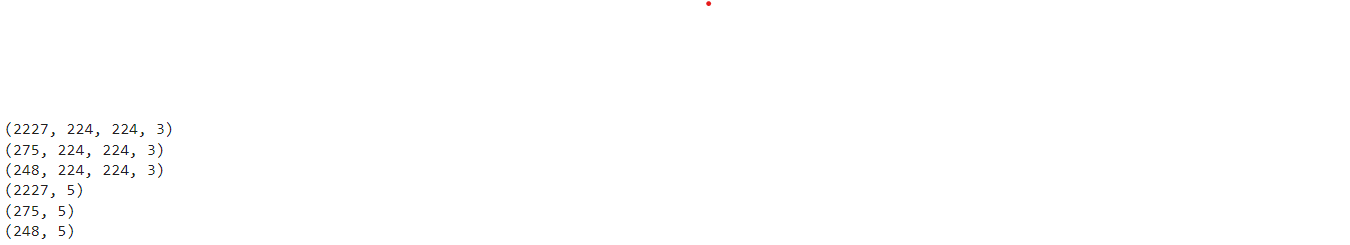

In [ ]:
#Creating learning schedules and custom learning rates to test.
from keras.callbacks import LearningRateScheduler

#Exponential entire time
def exponential_full_length(epoch, lr):
    x = 0
    while x < epoch:
        return lr * tf.math.exp(-0.1)
        x += 1
exponential_full_length_ls = LearningRateScheduler(exponential_full_length)

#Exponential after set threshold number of epochs
def exponential_thresholded(epoch, lr, threshold):
    while epoch < threshold + 1:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
exponential_threshold_ls = LearningRateScheduler(exponential_thresholded)

#Stepped learning rate - needs to be an argument to the optimizer. NOT a callback. Decay_steps should be samples / batch_size
stepped_initial_lr = 0.1
stepped_decay_steps = 2227 // 32
stepped_decay_rate = 0.97

stepped_learning_schedule = keras.optimizers.schedules.ExponentialDecay(stepped_initial_lr, decay_steps = stepped_decay_steps,
                                                                        decay_rate = stepped_decay_rate, staircase = True)
#polynomial learning rate 
polynomial_initial_lr = 0.1
polynomial_decay_steps = 2227 // 32
polynomial_end_lr = 0.0001
polynomial_power = 0.5 # square root

polynomial_learning_schedule = keras.optimizers.schedules.PolynomialDecay(polynomial_initial_lr, decay_steps = polynomial_decay_steps,
                                                                         end_learning_rate = polynomial_end_lr, power = polynomial_power)

#Early stopping callback - Patience = 5
early_stopping_patience = 5
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = 'val_loss')

In [ ]:
#Plotting function 

#Input: model name; model history; no. epochs
#Outputs: 2x1 grid with 2 graphs (loss and categorical accuracy); dataframe of metrics over epochs 

def plot_model_history(model_name, model_history, no_epochs, tick_interval, rolling_avg_interval):
    length_x_axis = int(no_epochs + 1)
    x_axis = np.arange(1, length_x_axis, tick_interval)
    
    model_history_df = pd.DataFrame(model_history.history)
    
    plt.figure(1, (20,20))
    plt.suptitle('metrics of ' +  model_name)
    
    #Accuracy measures
    plt.subplot(2, 2, 1)
    plt.title('Accuracy metrics', loc = 'left')
    plt.plot(model_history.history['categorical_accuracy'], label = 'Categorical Accuracy')
    plt.plot(model_history_df['categorical_accuracy'].rolling(window = rolling_avg_interval).mean(), label = 'Rolling Categorical Accuracy', marker = 'x', linestyle = 'dashed')
    plt.plot(model_history.history['val_categorical_accuracy'], label = 'Validation Categorical Accuracy')
    plt.plot(model_history_df['val_categorical_accuracy'].rolling(window = rolling_avg_interval).mean(), label = 'Rolling Validation Categorical Accuracy', marker = 'x', linestyle = 'dashed')
    plt.grid(False)
    plt.legend()
    
    #Loss measures
    plt.subplot(2, 2, 2)
    plt.title('Loss metrics', loc = 'left')
    plt.plot(model_history.history['loss'], label = 'Loss')
    plt.plot(model_history_df['loss'].rolling(window = rolling_avg_interval).mean(), label = 'Rolling Loss', marker = 'x', linestyle = 'dashed')
    plt.plot(model_history.history['val_loss'], label = 'Validation Loss')
    plt.plot(model_history_df['val_loss'].rolling(window = rolling_avg_interval).mean(), label = 'Rolling Validation Loss', marker = 'x', linestyle = 'dashed')
    plt.grid(False)
    plt.legend()
    
    
    #Save Graph figure 
    plt.savefig(fname = 'C:/Users/tomwr/Desktop/data_science_projects/diabetic_retinography_classification/graphs/{}'.format(model_name), format = 'png')
    
    #Save History Dataframe as a csv
    model_history_df.to_csv('C:/Users/tomwr/Desktop/data_science_projects/diabetic_retinography_classification/metric_dfs/{}'.format(model_name))
    
    

In [ ]:
#Function to display gridded labelled random images

def plot_image_grid(image_array, label_array, x_length, y_length, labels_list):
    
    fig, ax = plt.subplots(x_length, y_length)
    fig.set_size_inches(15, 15)
    for i in range(x_length):
        for j in range (y_length):
            l = random.randint(0, int(len(label_array)))
            ax[i, j].imshow(image_array[l])
            max_coded = np.argmax((label_array[l])) # GETS THE INDEX NUMBER 
            ax[i, j].set_title(labels_list[max_coded]) # WORKAROUND TO CONVERT ONE HOT ENCODED NP.ARRAYS INTO STRINGS - BY COMPARING TO A LIST INDEX
    
    plt.tight_layout() # prevent overlapping axes
        

In [ ]:
plot_image_grid(X_train, y_train, 5, 5, LABELS)


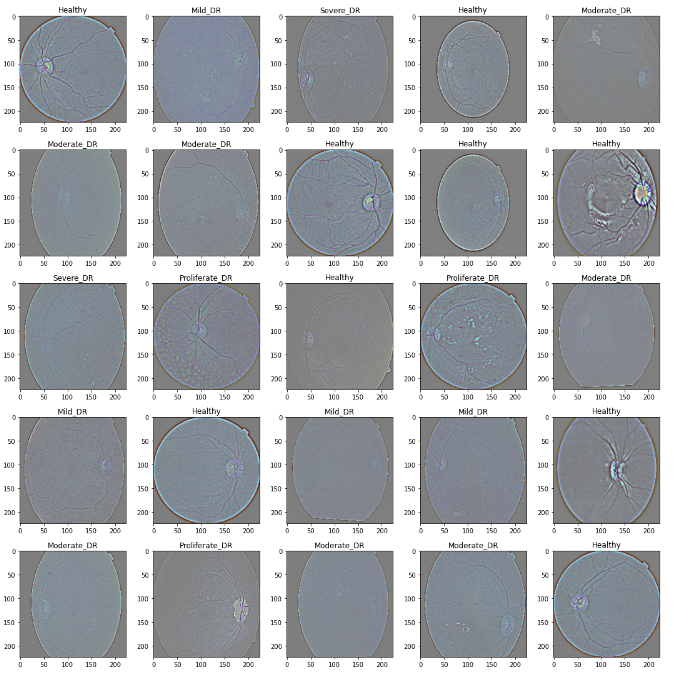

In [ ]:
#test functions so far 
pre_test_model_epochs = 6
pre_test_model_name = 'pre_test_model-' + str(pre_test_model_epochs) + '_' + str(time.time())

pre_test_model = keras.models.Sequential([
    keras.layers.Conv2D(input_shape = [IMG_DIM, IMG_DIM, 3], filters = 4, kernel_size = (5,5), padding = 'same', kernel_initializer = 'he_normal'),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(filters = 4, kernel_size = (3,3), padding = 'same', kernel_initializer = 'he_normal'),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same'),
    keras.layers.Flatten(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(len(LABELS)),
    keras.layers.Activation('softmax')
])

pre_test_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['categorical_accuracy'])
#pre_test_model_history = pre_test_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = pre_test_model_epochs)

#plot_model_history(pre_test_model_name, pre_test_model_history, pre_test_model_epochs, 1, 3) # name, history, no. epochs, tick interval, rolling avg.

In [ ]:
#Training data generators

from keras.preprocessing.image import ImageDataGenerator 

#Train, Standard
train_generator = ImageDataGenerator(featurewise_center = True,
                                    featurewise_std_normalization = True,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    zoom_range = 0.1,
                                    brightness_range = [0.1, 0.5],
                                    shear_range = 0.1)
train_generator.fit(X_train)

#Val, Standard
validation_generator = ImageDataGenerator()
validation_generator.fit(X_val)

#EfficientNetB1
#Train, Transfer
from tf.keras.applications import EfficientNetB1
enb1_X_train = keras.applications.efficientnet.preprocess_input(X_train * 255) # earlier X / 255.0
enb1_X_val = keras.applications.efficientnet.preprocess_input(X_val * 255)

enb1_train_generator = ImageDataGenerator(featurewise_center = True,
                                        featurewise_std_normalization = True,
                                        horizontal_flip = True,
                                        vertical_flip = True,
                                        zoom_range = 0.1, 
                                        brightness_range = [0.1, 0.5],
                                        shear_range = 0.1)
enb1_train_generator.fit(enb1_X_train)

#Validation, Transfer
enb1_validation_generator = ImageDataGenerator()
enb1_validation_generator.fit(enb1_X_val) 

In [ ]:
#empty dataframe to add model results to
train_test_results_df = pd.DataFrame(columns = ['name', 'loss', 'val_loss', 'test_loss', 'categorical_accuracy', 'val_categorical_accuracy', 'test_categorical_accuracy'])


def compare_train_test_results(train_history, test_results, model_name):
    
    #convert full training history to a dataframe
    train_history_df = pd.DataFrame(train_history.history)
    
    #select and copy last epoch
    last_epoch_train_history = train_history_df.iloc[[-1]].copy()
    
    #Reset train_history index so its now 0
    last_epoch_train_history.reset_index(drop = True) # drop = True - removes a newly formed 'index' column
    
    #Add a model name column to last_epoch_train_history
    last_epoch_train_history['name'] = str(model_name)
    
    #Convert test history dictionary into a dataframe
    test_history_df = pd.DataFrame(test_results, index = [0])
    
    #Add a model name column to test_history_df
    test_history_df['name'] = str(model_name)
    
    #rename Loss and Categorical Accuracy columns
    test_history_df = test_history_df.rename(columns = {'loss' : 'test_loss', 'categorical_accuracy' : 'test_categorical_accuracy'})
    
    #Join test_history_df onto last_epoch_train_history on model_name column
    train_test_join = last_epoch_train_history.merge(test_history_df, how = 'outer', on = 'name')
    
    #Reorder columns in train_test_join to match train_test_results_df order
    train_test_join[['name', 'loss', 'val_loss', 'test_loss', 'categorical_accuracy', 'val_categorical_accuracy', 'test_categorical_accuracy']]
    